# Data Analysis

This notebook is devoted to the analysis of the DWAVE data and the comparison between them and the data generated by the Neural Network (MADE for the moment) 

In [2]:
import glob
from typing import Sequence, List, Optional

from math import sqrt
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numba import jit

In [3]:
@jit(nopython=True)
def econf(Lx: int, J: np.ndarray, S0: np.ndarray) -> float:
    energy = 0.
    for kx in range(Lx):
        for ky in range(Lx):

            k = kx + (Lx * ky)
            R = kx + 1  # right spin
            D = ky + 1  # down spin

            kR = k - ky  # coupling to the right of S0[kx,ky]
            kD = k  # coupling to the down of S0[kx,ky]

            # Tries to find a spin to right, if no spin, contribution is 0.
            Rs = S0[R, ky] * J[kR, 0] if R % Lx != 0 else 0
            # Tries to find a spin to left, if no spin, contribution is 0.
            Ds = S0[kx, D] * J[kD, 1] if D % Lx != 0 else 0

            energy += -S0[kx, ky] * (Rs + Ds)
    return energy


In [4]:
def get_coupling_open(Lx: int = 22, seed: int = 12345):
    np.random.seed(seed)
    N=Lx**2
    return (np.random.normal(0.0, 1.0, size=(N - Lx, 2)))

In [5]:
def plot_hist(gen_paths: Sequence[str], truth_path: str = "/home/scriva/pixel-cnn/data/100-v1/train_100_lattice_2d_ising_spins.npy", seed: int = 12345, labels: Optional[List[str]] = None) -> None:
    if labels is None:
        labels = [f"eng{i}" for i, _ in enumerate(gen_paths)]

    truth = np.load(truth_path)
    
    try:
        truth = truth["sample"]
    except:
        print(f"No sample subdir found in {truth_path} \nLoading from path...")
        truth = truth

    truth = np.reshape(truth, (-1, int(sqrt(truth.shape[-1])), int(sqrt(truth.shape[-1]))), order='F')
    square_spin = truth.shape[-1]


    np.random.seed(seed)
    J = get_coupling_open(Lx=square_spin, seed=seed) # (square_spin, seed=seed)

    eng_truth = []
    for t in truth:
        eng_truth.append(econf(square_spin, J, t))
    eng_truth = np.asarray(eng_truth)
    
    engs= []
    for path in gen_paths:
        out = np.load(path)

        try:
            sample = out["sample"]
        except:
            print(f"No sample subdir found in {path} \nLoading from path...")
            sample = out
        
        sample = sample.squeeze()
        sample = np.reshape(sample, (-1, sample.shape[-1], sample.shape[-1]), order='F')
        sample.shape

        eng = []
        for s in sample:
            eng.append(econf(square_spin, J, s))
        eng = np.asarray(eng)

        engs.append(eng)

    fig = plt.figure(figsize=(8,8))
    
    font = {'size'   : 10, 'weight': 'bold'}
    plt.rc('font', **font)
    
    bins = np.linspace(eng_truth.min(),eng_truth.max()).tolist()

    for i, eng in enumerate(engs):
        _ = plt.hist(eng, bins=bins, log=True, label=f"{labels[i]}", alpha=0.8)
        print(f"eng {i} mean: {eng.mean()}")
    
    _ = plt.hist(eng_truth, bins=bins, log=True, label="DWave data", histtype='bar', ec='black', alpha=0.2)
    print(f"DWave data eng mean: {eng_truth.mean()}")

    plt.ylabel("Count", fontsize=18)
    plt.xlabel(r"$\frac{E}{N}$", fontsize=18)

    plt.ylim(1, 35000)
    plt.legend(prop={'size': 16})

    return engs, eng_truth

## Check energy

Load dataset as it is saved by [DWAVE system](https://cloud.dwavesys.com/leap/login/?next=/leap/). Since there is a maximum time for the annealing process, data are saved in files with maximum size of 10k sample. In the same folder one can find also two energy file, one computed directly by DWAVE annealer and the other one with our custom algorithm. Both should give us the same result. So, here we load the dataset and we rearrange them in two files, namely train and validation dataset.

In [6]:
files = glob.glob(f'../data/*open-simple_50mu/configs_*')

arrs = []
for file in files:
    arrs.append(np.load(file))
dataset = np.concatenate(arrs, axis=0)
train_data, test_data = train_test_split(dataset, test_size=0.15)

# Comment off the following lines to save the datasets.
# np.save('DWAVE-train-484spins-50mu', train_data)
# np.save('DWAVE-test-484spins-50mu', test_data)


Here we load a small part of the original dataset in order to check if the energy is well computed.

In [13]:
sample = np.load("../data/1-50k_open-simple_10mu/configs_0.npy")
dwave_eng = np.load("../data/1-50k_open-simple_10mu/dwave-engs_0.npy")
eng = np.loadtxt("../data/1-50k_open-simple_10mu/energies_0.txt")

print(f"Energy (from DWAVE) {dwave_eng[:4]}\nEnergy (our algo) {-eng[:4]*484}")

 Energy (from DWAVE) [-543.08267372 -552.56004167 -554.49060762 -550.73368602]
Energy (our algo) [-543.08267372 -552.56004167 -554.49060762 -550.73368602]


## Plot histograms

Here we want to check if the Neural Network has been well trained, a good measure could also be the mean energy of the DWAVE data and the generated data.

No sample subdir found in ../data/1-50k_open-simple_10mu/configs_0.npy 
Loading from path...
eng 0 mean: -544.1107000723495
DWave data eng mean: -546.6634890535129


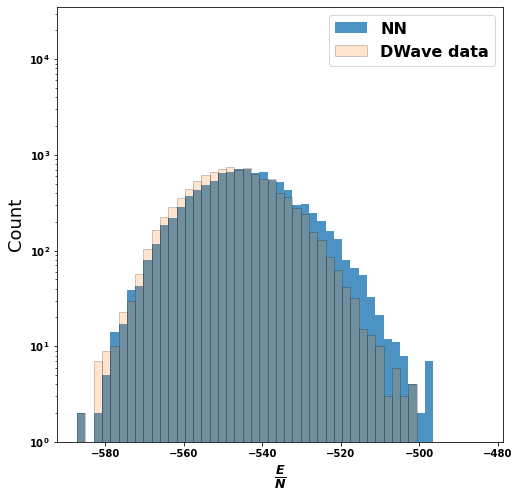

In [60]:
path=["../size-484_sample-100000_2.npz"]
labels=["NN"]
truth = "../data/1-50k_open-simple_10mu/configs_0.npy" 
engs, eng_truth = plot_hist(path, truth_path=truth, labels=labels)